In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler, minmax_scale
from torch.utils.data import DataLoader, Dataset, TensorDataset

from main_event import prepare_event_data, prepare_json_event_data
from models.neural_network import NeuralNetwork
from models.main import get_model, train_model
from preprocessing import PreProcessing
from utils import (
    calculate_velocity_acceleration,
    calculate_velocity_direction,
    calculate_velocity_acceleration_direction,
    get_frame_data,
    plot_accuracy_history,
    plot_confusion_matrix,
    calculate_player_ball_distances,
    track_closest_players,
    get_n_smallest_indices_sorted
)

## You'll see the data goes from 0 to 1 on each axis. The coordiante (0,0) is the top left, (1,1) is the bottom right, and (0.5,0.5) is the kick off point.

In [2]:
game_1_pre = PreProcessing()
game_1_data = game_1_pre.load_and_process_data(
    data_home="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [3]:
game_2_pre = PreProcessing()
game_2_data = game_2_pre.load_and_process_data(
    data_home="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [4]:
game_3_pre = PreProcessing()
game_3_data = game_3_pre.load_and_process_json_data(
    data_home_away="data/Sample_Game_3/Sample_Game_3_tracking.txt", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [5]:
# game_1_data.iloc[:, 25:-2] = -1 * game_1_data.iloc[:, 25:-2] 1414:1425
game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.45472,0.38709
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.49645,0.40656
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.53716,0.42556
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.55236,0.43313,0.50034,0.94391,0.43644,0.05038,0.37756,0.27473,0.55346,0.42231
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.55202,0.43311,0.50017,0.94434,0.43580,0.04977,0.37663,0.27543,0.55512,0.40570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.10317,0.81976,0.19836,0.45137,0.29416,0.48874,0.35600,0.55371,0.03058,0.99726
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.10319,0.81960,0.19831,0.45182,0.29373,0.48836,0.35583,0.55283,0.03058,0.99726
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.10285,0.81944,0.19805,0.45200,0.29331,0.48800,0.35561,0.55254,0.03058,0.99726
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.10231,0.81944,0.19766,0.45237,0.29272,0.48789,0.35532,0.55243,0.03058,0.99726


In [6]:
# game_2_data.iloc[:, 25:-2] = -1 * game_2_data.iloc[:, 25:-2]
game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
2,1.0,2.0,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
3,1.0,3.0,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
4,1.0,4.0,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
5,1.0,5.0,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2.0,141152.0,5646.08,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46751,1.05000,0.44966,0.41572,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141153,2.0,141153.0,5646.12,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46790,1.05000,0.44983,0.41550,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141154,2.0,141154.0,5646.16,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46818,1.05000,0.44997,0.41485,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141155,2.0,141155.0,5646.20,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46855,1.05000,0.45017,0.41515,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891


In [7]:
game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,0.41787,0.48086,0.41215,0.36689,0.47050,0.73219,0.48864,0.36357,0.50125,0.48725
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.41719,0.47864,0.41132,0.36169,0.47040,0.73204,0.48834,0.36362,0.50125,0.48725
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.41697,0.47824,0.41131,0.36072,0.47075,0.73229,0.48814,0.36372,0.50125,0.48725
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.41685,0.47815,0.41117,0.35930,0.47118,0.73266,0.48793,0.36278,0.50125,0.48725
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.41669,0.47749,0.41120,0.35910,0.47163,0.73287,0.48784,0.36240,0.50125,0.48725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.58877,0.56936,0.50218,0.65158,0.46978,0.62349,0.80792,0.27106,0.89207,0.50485
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.58787,0.56961,0.50180,0.65115,0.46970,0.62403,0.80712,0.27184,0.89207,0.50485
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.58668,0.57038,0.50116,0.65071,0.46929,0.62479,0.80582,0.27242,0.89207,0.50485
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.58525,0.57033,0.50031,0.65134,0.46866,0.62611,0.80444,0.27260,0.89207,0.50485


## Tracking for individual Players for the First Period

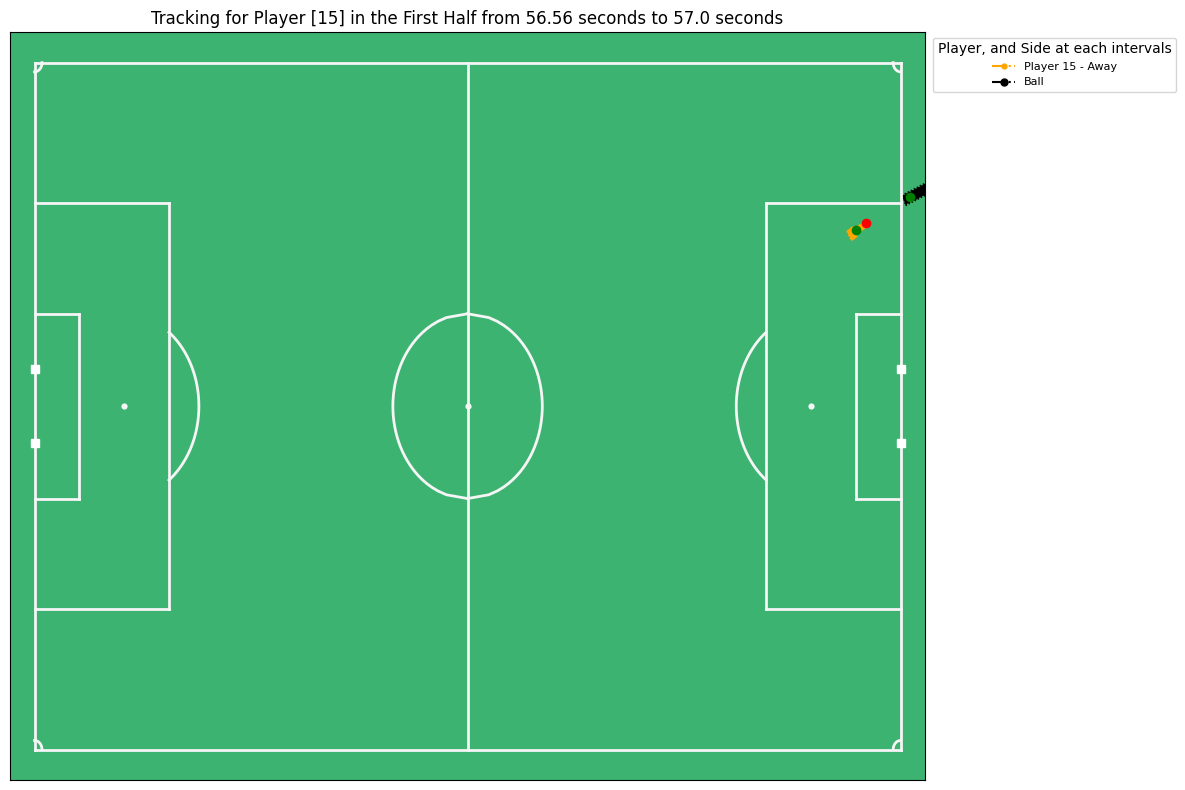

In [8]:
game_2_pre.player_visualization(game_1_data.loc[1414:1425], players=[15], sides=["Away"]*1, plot_ball=True)

In [9]:
# player_tracking(period_1_data)
# player_tracking(period_1_data_home, [2])
# player_tracking(period_1_data_home, [5])
# player_tracking(period_1_data_home, [8])

# Adding extra features to dataset

In [10]:
vel_acc_game_1_data = calculate_velocity_acceleration_direction(game_1_data)
vel_acc_game_2_data = calculate_velocity_acceleration_direction(game_2_data)
vel_acc_game_3_data = calculate_velocity_acceleration_direction(game_3_data)

In [11]:
vel_acc_game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,P_22_direction,P_23_velocity,P_23_acceleration,P_23_direction,P_24_velocity,P_24_acceleration,P_24_direction,Ball_velocity,Ball_acceleration,Ball_direction
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.0,-1.000000,NaN,0.0,-1.000000,NaN,0.0,-0.846472,NaN,0.422814
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.0,-1.000000,0.000000,0.0,-1.000000,-1.110223e-16,0.0,-0.850216,-0.002128,0.422922
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.902134,-0.997622,0.001189,0.592076,-0.992747,3.626733e-03,0.759852,-0.944585,-0.047479,-0.195538
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.929961,-0.996542,0.000540,-0.689938,-0.992872,-6.258403e-05,0.601374,-0.944346,-0.000134,-0.995043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.5547,-0.997870,0.000091,-0.697865,-0.995711,3.062708e-04,-0.985212,-1.000000,-0.000254,0.0
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.993884,-0.997756,0.000057,-0.662198,-0.994511,5.998815e-04,-0.981847,-1.000000,-0.000254,0.0
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.56921,-0.997837,-0.000040,-0.650791,-0.997771,-1.629783e-03,-0.796691,-1.000000,-0.000254,0.0
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.68826,-0.997653,0.000092,-0.183282,-0.998101,-1.648699e-04,-0.354654,-1.000000,-0.000254,0.0


In [12]:
vel_acc_game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,P_22_direction,P_23_velocity,P_23_acceleration,P_23_direction,P_24_velocity,P_24_acceleration,P_24_direction,Ball_velocity,Ball_acceleration,Ball_direction
1,1.0,1.0,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>
2,1.0,2.0,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.0,-1.0,NaN,0.0,-1.0,NaN,0.0,-1.0,NaN,0.0
3,1.0,3.0,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.0,-1.0,0.001487,0.0,-1.0,0.001491,0.0,-1.0,-0.002262,0.0
4,1.0,4.0,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.0,-1.0,0.001487,0.0,-1.0,0.001491,0.0,-1.0,-0.002262,0.0
5,1.0,5.0,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.0,-1.0,0.001487,0.0,-1.0,0.001491,0.0,-1.0,-0.002262,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2.0,141152.0,5646.08,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,-0.8,-1.0,0.001487,0.0,-1.0,0.001491,0.0,-1.0,-0.002262,0.0
141153,2.0,141153.0,5646.12,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,-0.791285,-1.0,0.001487,0.0,-1.0,0.001491,0.0,-1.0,-0.002262,0.0
141154,2.0,141154.0,5646.16,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,-0.977582,-1.0,0.001487,0.0,-1.0,0.001491,0.0,-1.0,-0.002262,0.0
141155,2.0,141155.0,5646.20,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.83205,-1.0,0.001487,0.0,-1.0,0.001491,0.0,-1.0,-0.002262,0.0


In [13]:
game_1_ply_tra = vel_acc_game_1_data.iloc[:, 3:]
game_2_ply_tra = vel_acc_game_2_data.iloc[:, 3:]
game_3_ply_tra = vel_acc_game_3_data.iloc[:, 2:] # This is different

In [14]:
game_2_ply_tra

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_22_direction,P_23_velocity,P_23_acceleration,P_23_direction,P_24_velocity,P_24_acceleration,P_24_direction,Ball_velocity,Ball_acceleration,Ball_direction
1,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>
2,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.0,-1.0,NaN,0.0,-1.0,NaN,0.0,-1.0,NaN,0.0
3,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.0,-1.0,0.001487,0.0,-1.0,0.001491,0.0,-1.0,-0.002262,0.0
4,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.0,-1.0,0.001487,0.0,-1.0,0.001491,0.0,-1.0,-0.002262,0.0
5,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.0,-1.0,0.001487,0.0,-1.0,0.001491,0.0,-1.0,-0.002262,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,-0.8,-1.0,0.001487,0.0,-1.0,0.001491,0.0,-1.0,-0.002262,0.0
141153,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,-0.791285,-1.0,0.001487,0.0,-1.0,0.001491,0.0,-1.0,-0.002262,0.0
141154,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,-0.977582,-1.0,0.001487,0.0,-1.0,0.001491,0.0,-1.0,-0.002262,0.0
141155,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.83205,-1.0,0.001487,0.0,-1.0,0.001491,0.0,-1.0,-0.002262,0.0


In [15]:
# game_1_player_data = get_frame_data(game_1_ply_tra, columns=game_1_ply_tra.columns[0:46:2], feature="direction").fillna(0)
# game_2_player_data = get_frame_data(game_2_ply_tra, columns=game_2_ply_tra.columns[0:46:2], feature="direction").fillna(0)
# game_3_player_data = get_frame_data(game_3_ply_tra, columns=game_3_ply_tra.columns[0:46:2], feature="direction").fillna(0)

In [16]:
game_1_player_data = game_1_ply_tra.fillna(0).copy()
game_2_player_data = game_2_ply_tra.fillna(0).copy()
game_3_player_data = game_3_ply_tra.fillna(0).copy()

In [17]:
game_1_player_data

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_22_direction,P_23_velocity,P_23_acceleration,P_23_direction,P_24_velocity,P_24_acceleration,P_24_direction,Ball_velocity,Ball_acceleration,Ball_direction
1,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.0
2,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,0.0,-1.000000,0.000000,0.0,-1.000000,0.000000e+00,0.0,-0.846472,0.000000,0.422814
3,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,0.0,-1.000000,0.000000,0.0,-1.000000,-1.110223e-16,0.0,-0.850216,-0.002128,0.422922
4,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,0.35554,0.32142,0.21241,...,0.902134,-0.997622,0.001189,0.592076,-0.992747,3.626733e-03,0.759852,-0.944585,-0.047479,-0.195538
5,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,0.35528,0.32136,0.21159,...,0.929961,-0.996542,0.000540,-0.689938,-0.992872,-6.258403e-05,0.601374,-0.944346,-0.000134,-0.995043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,0.67513,0.11428,0.92765,...,0.5547,-0.997870,0.000091,-0.697865,-0.995711,3.062708e-04,-0.985212,-1.000000,-0.000254,0.0
145003,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,0.67529,0.11428,0.92765,...,0.993884,-0.997756,0.000057,-0.662198,-0.994511,5.998815e-04,-0.981847,-1.000000,-0.000254,0.0
145004,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,0.67501,0.11428,0.92765,...,0.56921,-0.997837,-0.000040,-0.650791,-0.997771,-1.629783e-03,-0.796691,-1.000000,-0.000254,0.0
145005,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,0.67468,0.11428,0.92765,...,0.68826,-0.997653,0.000092,-0.183282,-0.998101,-1.648699e-04,-0.354654,-1.000000,-0.000254,0.0


# Classification

In [18]:
game_1_event = prepare_event_data("data/Sample_Game_1/Sample_Game_1_RawEventsData.csv", game_1_data)
game_2_event = prepare_event_data("data/Sample_Game_2/Sample_Game_2_RawEventsData.csv", game_2_data)
game_3_event = prepare_json_event_data("data/Sample_Game_3/Sample_Game_3_events.json", game_3_data)

In [19]:
game_1_event

,Type
3,PASS
4,PASS
5,PASS
6,PASS
7,PASS
...,...
143614,BALL LOST
143615,BALL LOST
143616,BALL LOST
143617,BALL LOST


In [20]:
game_2_event

,Type
146,PASS
147,PASS
148,PASS
149,PASS
150,PASS
...,...
141152,BALL OUT
141153,BALL OUT
141154,BALL OUT
141155,BALL OUT


In [21]:
game_3_event

,Type
384,PASS
385,PASS
386,PASS
387,PASS
388,PASS
...,...
143529,PASS
143530,PASS
143531,PASS
143532,PASS


In [22]:
common_indices = game_1_event.index.intersection(game_1_player_data.index)
X_1 = game_1_player_data.loc[common_indices]
y_1 = game_1_event.loc[common_indices]

assert X_1.shape[0] == y_1.shape[0]

In [23]:
common_indices = game_2_event.index.intersection(game_2_player_data.index)
X_2 = game_2_player_data.loc[common_indices]
y_2 = game_2_event.loc[common_indices]

assert X_2.shape[0] == y_2.shape[0]

In [24]:
common_indices = game_3_event.index.intersection(game_3_player_data.index)
X_3 = game_3_player_data.loc[common_indices]
y_3 = game_3_event.loc[common_indices]

assert X_3.shape[0] == y_3.shape[0]

In [25]:
X_1

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_22_direction,P_23_velocity,P_23_acceleration,P_23_direction,P_24_velocity,P_24_acceleration,P_24_direction,Ball_velocity,Ball_acceleration,Ball_direction
3,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,0.0,-1.000000,0.000000,0.0,-1.000000,-1.110223e-16,0.0,-0.850216,-0.002128,0.422922
4,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,0.35554,0.32142,0.21241,...,0.902134,-0.997622,0.001189,0.592076,-0.992747,3.626733e-03,0.759852,-0.944585,-0.047479,-0.195538
5,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,0.35528,0.32136,0.21159,...,0.929961,-0.996542,0.000540,-0.689938,-0.992872,-6.258403e-05,0.601374,-0.944346,-0.000134,-0.995043
6,0.00140,0.48238,0.32581,0.65159,0.33637,0.48966,0.30978,0.35479,0.32159,0.21051,...,-0.071247,-0.995303,0.000620,-0.774328,-0.989728,1.571950e-03,0.775019,-0.944349,-0.000256,-0.995102
7,0.00140,0.48238,0.32570,0.65037,0.33624,0.48919,0.31015,0.35439,0.32198,0.20921,...,-0.742393,-0.995575,-0.000136,-0.698213,-0.991338,-8.049408e-04,0.551433,-0.944349,-0.000254,-0.995102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143614,0.87621,0.48890,0.25147,0.54818,0.47196,0.44820,0.50936,0.57808,0.11104,0.67714,...,0.447214,-0.996472,-0.000259,0.809215,-0.987762,-7.220017e-05,0.195154,-0.983072,-0.000265,-0.777978
143615,0.87601,0.48911,0.25096,0.54821,0.47157,0.44844,0.50890,0.57796,0.11004,0.67616,...,0.404595,-0.996613,-0.000070,0.808236,-0.987954,-9.605656e-05,0.193182,-0.983051,-0.000244,-0.777016
143616,0.87583,0.48933,0.25045,0.54823,0.47120,0.44872,0.50844,0.57788,0.10914,0.67526,...,0.438424,-0.996676,-0.000031,0.8,-0.988086,-6.597336e-05,0.190182,-0.983072,-0.000265,-0.777978
143617,0.87564,0.48954,0.24996,0.54830,0.47084,0.44899,0.50799,0.57768,0.10829,0.67433,...,0.471157,-0.996385,0.000145,0.854616,-0.988108,-1.134267e-05,0.180245,-0.983025,-0.000231,-0.777793


### Adding which team has the ball using distance metrics

In [26]:
game_1_players, game_1_ball, game_1_vel_acc = vel_acc_game_1_data.loc[X_1.index, "Home-Player11-x":"Away-Player24-y"], vel_acc_game_1_data.loc[X_1.index, "Ball-x":"Ball-y"], vel_acc_game_1_data.loc[X_1.index, "P_11_velocity":]
game_2_players, game_2_ball, game_2_vel_acc = vel_acc_game_2_data.loc[X_2.index, "Home-Player11-x":"Away-Player24-y"], vel_acc_game_2_data.loc[X_2.index, "Ball-x":"Ball-y"], vel_acc_game_2_data.loc[X_2.index, "P_11_velocity":]
game_3_players, game_3_ball, game_3_vel_acc = vel_acc_game_3_data.loc[X_3.index, "Home-Player11-x":"Away-Player24-y"], vel_acc_game_3_data.loc[X_3.index, "Ball-x":"Ball-y"], vel_acc_game_3_data.loc[X_3.index, "P_11_velocity":]

In [27]:
game_1_result = calculate_player_ball_distances(
    game_data=game_1_data.loc[X_1.index],
    player_data=game_1_players,
    ball_data=game_1_ball
)
game_1_result

,Time [s],Home-Player11,Home-Player1,Home-Player2,Home-Player3,Home-Player4,Home-Player5,Home-Player6,Home-Player7,Home-Player8,...,Away-Player15,Away-Player16,Away-Player17,Away-Player18,Away-Player19,Away-Player20,Away-Player21,Away-Player22,Away-Player23,Away-Player24
3,0.12,0.539023,0.310186,0.209852,0.238478,0.303165,0.325775,0.131295,0.176923,0.229466,...,0.222589,0.145477,0.365426,0.229583,0.090974,0.253186,0.016853,0.518945,0.388685,0.219656
4,0.16,0.555507,0.323936,0.226885,0.252990,0.312891,0.335267,0.147990,0.188744,0.234062,...,0.215733,0.131024,0.363269,0.241644,0.104642,0.255527,0.010876,0.524298,0.389905,0.229610
5,0.20,0.559113,0.336918,0.234244,0.250761,0.303846,0.350554,0.156768,0.182844,0.220835,...,0.197277,0.135839,0.378605,0.255965,0.102534,0.272252,0.027585,0.541436,0.375398,0.220973
6,0.24,0.563151,0.349641,0.242261,0.249360,0.295297,0.365688,0.166072,0.177541,0.208422,...,0.179660,0.142050,0.393339,0.269474,0.102840,0.287690,0.043790,0.558136,0.361370,0.213209
7,0.28,0.567758,0.362466,0.250968,0.248928,0.287334,0.380255,0.176221,0.173689,0.196685,...,0.162456,0.149593,0.408004,0.282869,0.105487,0.302437,0.059987,0.574458,0.347387,0.207090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143614,5744.56,0.804350,0.185293,0.427381,0.428353,0.056973,0.095513,0.184103,0.519533,0.082591,...,0.114894,0.030264,0.086602,0.363107,0.154489,0.155523,0.009879,0.381254,0.393613,0.225027
143615,5744.60,0.806604,0.186092,0.428208,0.430656,0.060635,0.092409,0.186681,0.518725,0.080450,...,0.116965,0.026288,0.089510,0.362792,0.151052,0.156188,0.015445,0.378841,0.394586,0.225026
143616,5744.64,0.808892,0.187006,0.429086,0.432985,0.064416,0.090174,0.189370,0.517919,0.078450,...,0.119181,0.023143,0.092503,0.362527,0.147764,0.156886,0.021004,0.376427,0.395626,0.225129
143617,5744.68,0.811206,0.188044,0.430041,0.435382,0.068212,0.090508,0.192103,0.517189,0.076664,...,0.121536,0.021172,0.095605,0.362424,0.144597,0.157611,0.026631,0.374041,0.396738,0.225333


In [28]:
game_2_result = calculate_player_ball_distances(
    game_data=game_2_data.loc[X_2.index],
    player_data=game_2_players,
    ball_data=game_2_ball
)
game_2_result

,Time [s],Home-Player11,Home-Player1,Home-Player2,Home-Player3,Home-Player4,Home-Player5,Home-Player6,Home-Player7,Home-Player8,...,Away-Player15,Away-Player16,Away-Player17,Away-Player18,Away-Player19,Away-Player20,Away-Player21,Away-Player22,Away-Player23,Away-Player24
146,5.84,0.496703,0.342948,0.277024,0.236026,0.373352,0.313091,0.180737,0.153203,0.257618,...,0.300610,0.114074,0.135304,0.244139,0.380443,0.000552,0.156475,0.510173,0.154591,0.171414
147,5.88,0.495560,0.339008,0.274342,0.236814,0.377921,0.307608,0.177571,0.154230,0.262085,...,0.306740,0.118177,0.130822,0.238153,0.385671,0.006124,0.150416,0.503450,0.156447,0.167461
148,5.92,0.494714,0.335354,0.272058,0.237919,0.382450,0.302357,0.174755,0.155649,0.266488,...,0.312700,0.122323,0.126521,0.232338,0.390834,0.012529,0.144592,0.496938,0.158735,0.163931
149,5.96,0.493924,0.331728,0.269874,0.239181,0.387007,0.297109,0.172067,0.157306,0.270939,...,0.318660,0.126717,0.122443,0.226515,0.396016,0.019004,0.138811,0.490421,0.161263,0.160582
150,6.00,0.493213,0.328212,0.267811,0.240609,0.391537,0.291942,0.169492,0.159178,0.275354,...,0.324600,0.131340,0.118528,0.220701,0.401187,0.025408,0.133247,0.483911,0.164015,0.157506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,5646.08,0.651304,0.194034,0.488442,0.386535,0.183404,0.118986,0.603386,0.602958,0.989591,...,0.081458,0.493244,0.641833,0.649969,0.583007,0.450188,1.090450,0.456393,0.672318,0.169162
141153,5646.12,0.651304,0.194034,0.488442,0.386535,0.183404,0.118986,0.603189,0.602958,0.990306,...,0.081458,0.492950,0.642163,0.649860,0.583427,0.450188,1.090471,0.456189,0.672318,0.169162
141154,5646.16,0.651304,0.194034,0.488442,0.386535,0.183404,0.118986,0.602523,0.602958,0.991150,...,0.081458,0.492180,0.642544,0.650310,0.583837,0.450188,1.090486,0.455554,0.672318,0.169162
141155,5646.20,0.651304,0.194034,0.488442,0.386535,0.183404,0.118986,0.601309,0.602958,0.991955,...,0.081458,0.489952,0.642961,0.650757,0.584248,0.450188,1.090506,0.455871,0.672318,0.169162


In [29]:
game_3_result = calculate_player_ball_distances(
    game_data=game_3_data.loc[X_3.index],
    player_data=game_3_players,
    ball_data=game_3_ball
)
game_3_result

,Time [s],Home-Player11,Home-Player1,Home-Player2,Home-Player3,Home-Player4,Home-Player5,Home-Player6,Home-Player7,Home-Player8,...,Away-Player15,Away-Player16,Away-Player17,Away-Player18,Away-Player19,Away-Player20,Away-Player21,Away-Player22,Away-Player23,Away-Player24
384,15.36,0.352504,0.331159,0.256519,0.284357,0.429872,0.378481,0.119092,0.000400,0.180356,...,0.346157,0.223549,0.211809,0.328314,0.132664,0.086096,0.074542,0.142414,0.148002,0.117704
385,15.40,0.351206,0.332361,0.255612,0.282324,0.428503,0.380764,0.117909,0.003158,0.178264,...,0.345420,0.223845,0.213747,0.330944,0.131090,0.085358,0.075985,0.144785,0.145465,0.118950
386,15.44,0.348255,0.334462,0.253864,0.277877,0.425091,0.384800,0.115926,0.008345,0.173728,...,0.343813,0.224480,0.217718,0.335997,0.128306,0.084851,0.079418,0.149504,0.141060,0.122100
387,15.48,0.345348,0.336726,0.252235,0.273450,0.421719,0.388662,0.114108,0.013467,0.169228,...,0.342284,0.225251,0.221681,0.341090,0.125653,0.084581,0.082921,0.154277,0.136661,0.125282
388,15.52,0.342459,0.339027,0.250612,0.269035,0.418362,0.392650,0.112378,0.018609,0.164744,...,0.340763,0.226084,0.225644,0.346147,0.123156,0.084541,0.086549,0.159133,0.132340,0.128482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143529,5741.16,0.757354,0.451340,0.512179,0.456022,0.484797,0.294182,0.351505,0.283820,0.373873,...,0.629015,0.075225,0.365217,0.600645,0.393664,0.412268,0.252676,0.422322,0.467580,0.351770
143530,5741.20,0.759984,0.452956,0.516748,0.459150,0.484995,0.298928,0.355475,0.285778,0.371533,...,0.626339,0.076360,0.370834,0.606412,0.397196,0.412906,0.256383,0.427348,0.470827,0.347940
143531,5741.24,0.762663,0.454658,0.521307,0.462330,0.485265,0.303622,0.359477,0.287854,0.369232,...,0.623813,0.077862,0.376445,0.612175,0.400782,0.413675,0.260164,0.432423,0.474142,0.344226
143532,5741.28,0.765381,0.456408,0.525908,0.465563,0.485640,0.308268,0.363557,0.290019,0.367110,...,0.621293,0.079760,0.382045,0.617958,0.404413,0.414503,0.264029,0.437502,0.477498,0.340496


In [30]:
game_1_closest_to_ball = get_n_smallest_indices_sorted(game_1_result.iloc[:, 1:], 1)
game_2_closest_to_ball = get_n_smallest_indices_sorted(game_2_result.iloc[:, 1:], 1)
game_3_closest_to_ball = get_n_smallest_indices_sorted(game_3_result.iloc[:, 1:], 1)
game_3_closest_to_ball

,P-1
384,Home-Player7
385,Home-Player7
386,Home-Player7
387,Home-Player7
388,Home-Player7
...,...
143529,Away-Player25
143530,Away-Player25
143531,Away-Player25
143532,Away-Player25


In [31]:
def add_ball_with(closest_to_ball: pd.DataFrame):
    # Assume the column of interest is the first column.
    col = closest_to_ball.iloc[:, 0].str.lower()
    
    # Use numpy.where to vectorize the assignment.
    team = np.where(col.str.startswith("home"), 0, 
                    np.where(col.str.startswith("away"), 1, np.nan))
    return team

In [32]:
X_1["Team"] = add_ball_with(game_1_closest_to_ball)
X_2["Team"] = add_ball_with(game_2_closest_to_ball)
X_3["Team"] = add_ball_with(game_3_closest_to_ball)

In [46]:
away_cols = X_1.columns.str.startswith("Away")
X_1.loc[:, away_cols] = X_1.loc[:, away_cols] * -1

away_cols = X_2.columns.str.startswith("Away")
X_2.loc[:, away_cols] = X_2.loc[:, away_cols] * -1

away_cols = X_3.columns.str.startswith("Away")
X_3.loc[:, away_cols] = X_3.loc[:, away_cols] * -1

In [51]:
X_1

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_23_velocity,P_23_acceleration,P_23_direction,P_24_velocity,P_24_acceleration,P_24_direction,Ball_velocity,Ball_acceleration,Ball_direction,Team
3,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,-1.000000,0.000000,0.0,-1.000000,-1.110223e-16,0.0,-0.850216,-0.002128,0.422922,0.0
4,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,0.35554,0.32142,0.21241,...,-0.997622,0.001189,0.592076,-0.992747,3.626733e-03,0.759852,-0.944585,-0.047479,-0.195538,0.0
5,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,0.35528,0.32136,0.21159,...,-0.996542,0.000540,-0.689938,-0.992872,-6.258403e-05,0.601374,-0.944346,-0.000134,-0.995043,0.0
6,0.00140,0.48238,0.32581,0.65159,0.33637,0.48966,0.30978,0.35479,0.32159,0.21051,...,-0.995303,0.000620,-0.774328,-0.989728,1.571950e-03,0.775019,-0.944349,-0.000256,-0.995102,0.0
7,0.00140,0.48238,0.32570,0.65037,0.33624,0.48919,0.31015,0.35439,0.32198,0.20921,...,-0.995575,-0.000136,-0.698213,-0.991338,-8.049408e-04,0.551433,-0.944349,-0.000254,-0.995102,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143614,0.87621,0.48890,0.25147,0.54818,0.47196,0.44820,0.50936,0.57808,0.11104,0.67714,...,-0.996472,-0.000259,0.809215,-0.987762,-7.220017e-05,0.195154,-0.983072,-0.000265,-0.777978,1.0
143615,0.87601,0.48911,0.25096,0.54821,0.47157,0.44844,0.50890,0.57796,0.11004,0.67616,...,-0.996613,-0.000070,0.808236,-0.987954,-9.605656e-05,0.193182,-0.983051,-0.000244,-0.777016,1.0
143616,0.87583,0.48933,0.25045,0.54823,0.47120,0.44872,0.50844,0.57788,0.10914,0.67526,...,-0.996676,-0.000031,0.8,-0.988086,-6.597336e-05,0.190182,-0.983072,-0.000265,-0.777978,1.0
143617,0.87564,0.48954,0.24996,0.54830,0.47084,0.44899,0.50799,0.57768,0.10829,0.67433,...,-0.996385,0.000145,0.854616,-0.988108,-1.134267e-05,0.180245,-0.983025,-0.000231,-0.777793,1.0


In [52]:
scaler = MinMaxScaler()
X_1_scaled = X_1.iloc[:, :].values.astype(float)#scaler.fit_transform(X_1)
X_2_scaled = X_2.iloc[:, :].values.astype(float)#scaler.transform(X_2)
X_3_scaled = X_3.iloc[:, :].values.astype(float)#scaler.transform(X_3)

In [53]:
label_encoder = LabelEncoder()
y_1_encoded = label_encoder.fit_transform(y_1).ravel()
y_2_encoded = label_encoder.transform(y_2).ravel()
y_3_encoded = label_encoder.transform(y_3).ravel()

C:\Users\noill\OneDrive\Desktop\module\Masters Thesis\Thesis\Real-Time LLM Football Commentary\.venv\lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\noill\OneDrive\Desktop\module\Masters Thesis\Thesis\Real-Time LLM Football Commentary\.venv\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\noill\OneDrive\Desktop\module\Masters Thesis\Thesis\Real-Time LLM Football Commentary\.venv\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, )

In [54]:
print(np.unique(y_1_encoded, return_counts=True))
print(np.unique(y_2_encoded, return_counts=True))
print(np.unique(y_3_encoded, return_counts=True))

(array([0, 1, 2, 3]), array([10071, 19023, 28145,   546], dtype=int64))
(array([0, 1, 2, 3]), array([ 7742, 15537, 32338,   485], dtype=int64))
(array([0, 1, 2, 3]), array([11107, 19620, 42896,   391], dtype=int64))


In [55]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(device)
    print(f"Using {device}: {device_name}")
else:
    device = torch.device("cpu")
    print(f"Using {device} device")

Using cuda: NVIDIA GeForce RTX 3060 Laptop GPU


In [56]:
assert X_1.shape[1] == X_2.shape[1] == X_3.shape[1]

nn_params = {
    "input_size": X_1.shape[1],
    "num_classes": np.unique(y_1).shape[0],
    "num_hidden_layers": 8,
    "dropout_rate": 0.0,
    "hidden_size": 256,
    "use_batch_norm": True
}

learning_rate = 0.001
batch_size = 256
num_epochs = 30

In [97]:
X = np.random.rand(30, 10)
y = np.concatenate([np.zeros(10), np.ones(10), np.full(10, 2)])
assert X.shape[0] == y.shape[0]

X = X.reshape(-1, 5, 10)
y = y.reshape(-1, 5)
print(X.shape)
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

d_1 = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(d_1, batch_size=4, shuffle=True)


(6, 5, 10)


In [98]:
for i, j in train_loader:
    print(j)

tensor([[2, 2, 2, 2, 2],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2]])
tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]])


In [57]:
X_1_tensor = torch.FloatTensor(X_1_scaled)
y_1_tensor = torch.LongTensor(y_1_encoded)

X_2_tensor = torch.FloatTensor(X_2_scaled)
y_2_tensor = torch.LongTensor(y_2_encoded)

X_3_tensor = torch.FloatTensor(X_3_scaled)
y_3_tensor = torch.LongTensor(y_3_encoded)

X = torch.cat((X_1_tensor, X_2_tensor))
y = torch.cat((y_1_tensor, y_2_tensor))

assert X.shape[0] == y.shape[0]

d_1 = TensorDataset(X, y)
d_2 = TensorDataset(X_3_tensor, y_3_tensor)

train_loader = DataLoader(d_1, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(d_2, batch_size=batch_size, shuffle=False)

In [58]:
nn_model = get_model(NeuralNetwork, params=nn_params).to(device)
nn_model

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=116, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.0, inplace=False)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.0, inplace=False)
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.0, inplace=False)
    (16): Linear(in_features=256, out_features=256, bias=True)
    (17): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True,

In [59]:
acc, y_train, y_train_pred, y_true, y_pred = train_model(nn_model, train_loader, validation_loader, num_epochs, "adam", nn.CrossEntropyLoss(), learning_rate, device)

Epoch  1/30: Train accuracy: 91.34% | Val accuracy: 60.35% | Train loss: 0.2444 | Val loss: 1.5186 | learning rate: 0.001000 | Precision: 58.77% | Recall: 60.35% | F1: 58.72%
Epoch  2/30: Train accuracy: 97.71% | Val accuracy: 61.32% | Train loss: 0.0756 | Val loss: 1.7450 | learning rate: 0.001000 | Precision: 58.74% | Recall: 61.32% | F1: 58.01%
Epoch  3/30: Train accuracy: 98.24% | Val accuracy: 62.37% | Train loss: 0.0595 | Val loss: 1.7892 | learning rate: 0.001000 | Precision: 59.01% | Recall: 62.37% | F1: 59.58%
Epoch  4/30: Train accuracy: 98.48% | Val accuracy: 61.84% | Train loss: 0.0494 | Val loss: 1.8655 | learning rate: 0.001000 | Precision: 58.47% | Recall: 61.84% | F1: 58.54%
Epoch  5/30: Train accuracy: 98.60% | Val accuracy: 60.93% | Train loss: 0.0476 | Val loss: 2.0290 | learning rate: 0.001000 | Precision: 57.91% | Recall: 60.93% | F1: 56.39%
Epoch  6/30: Train accuracy: 98.63% | Val accuracy: 61.47% | Train loss: 0.0454 | Val loss: 1.8016 | learning rate: 0.001000 

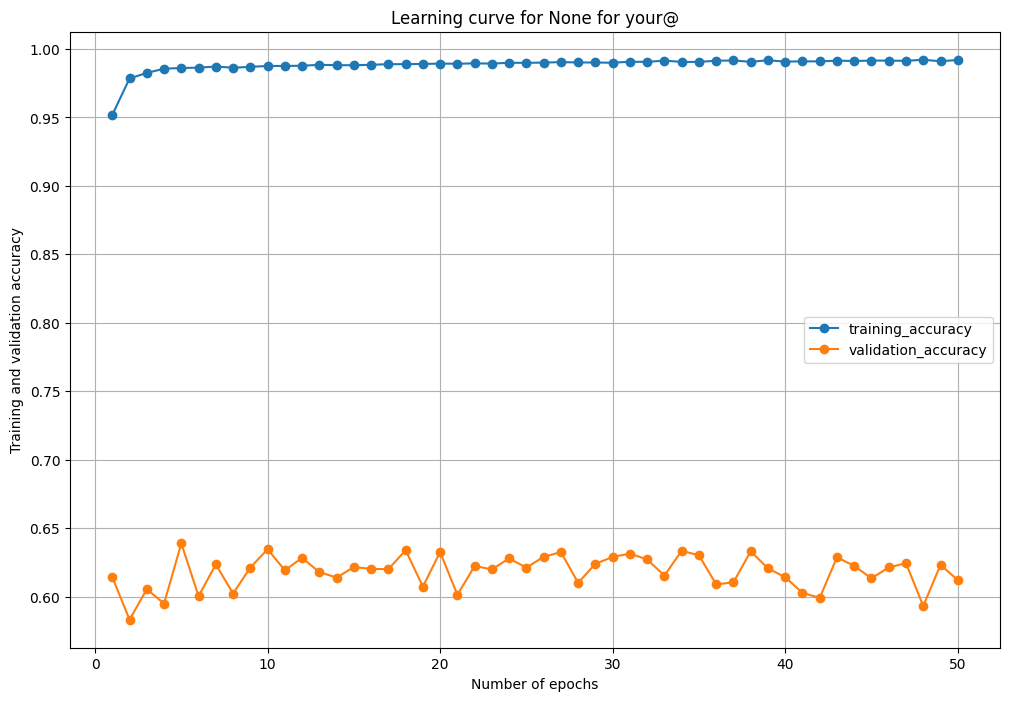

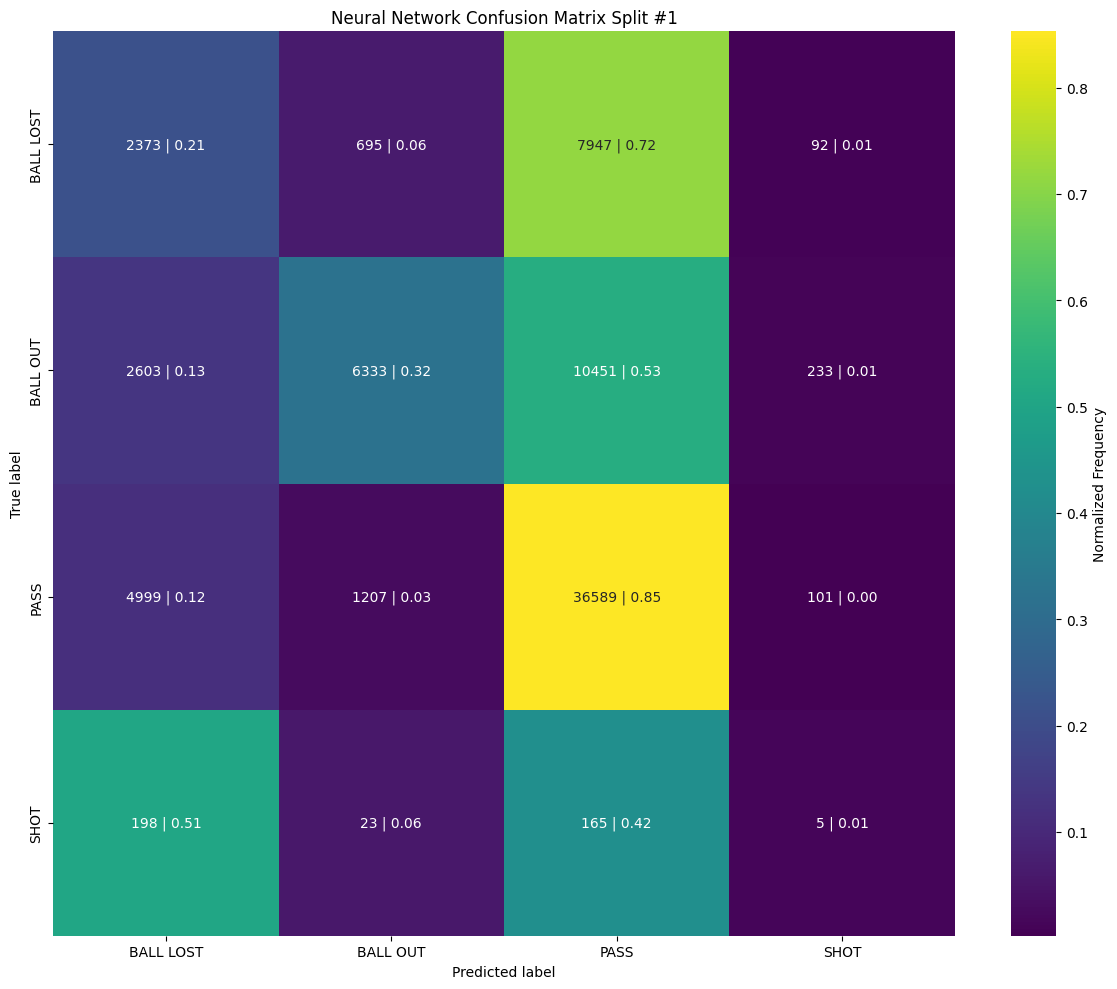

Neural Network training accuracy: 99.20%
Neural Network testing accuracy: 61.20%

Neural Network testing precision: 62.29%
Neural Network testing recall: 61.20%
Neural Network testing f1: 58.65%




In [45]:
plot_accuracy_history(acc, title="None for your@")
labels = label_encoder.inverse_transform(np.unique(y_1_encoded))
_ = plot_confusion_matrix(y_train=label_encoder.inverse_transform(y_train), y_train_pred=label_encoder.inverse_transform(y_train_pred), y_test=label_encoder.inverse_transform(y_true), 
                          y_pred=label_encoder.inverse_transform(y_pred), labels=labels, split=0, model_name="Neural Network")

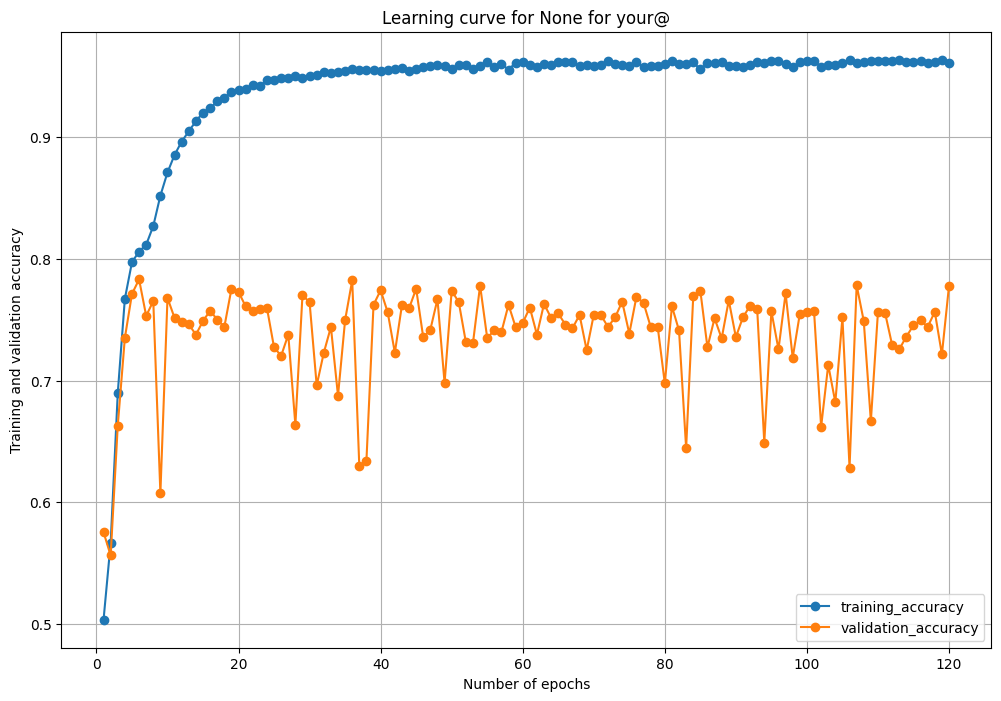

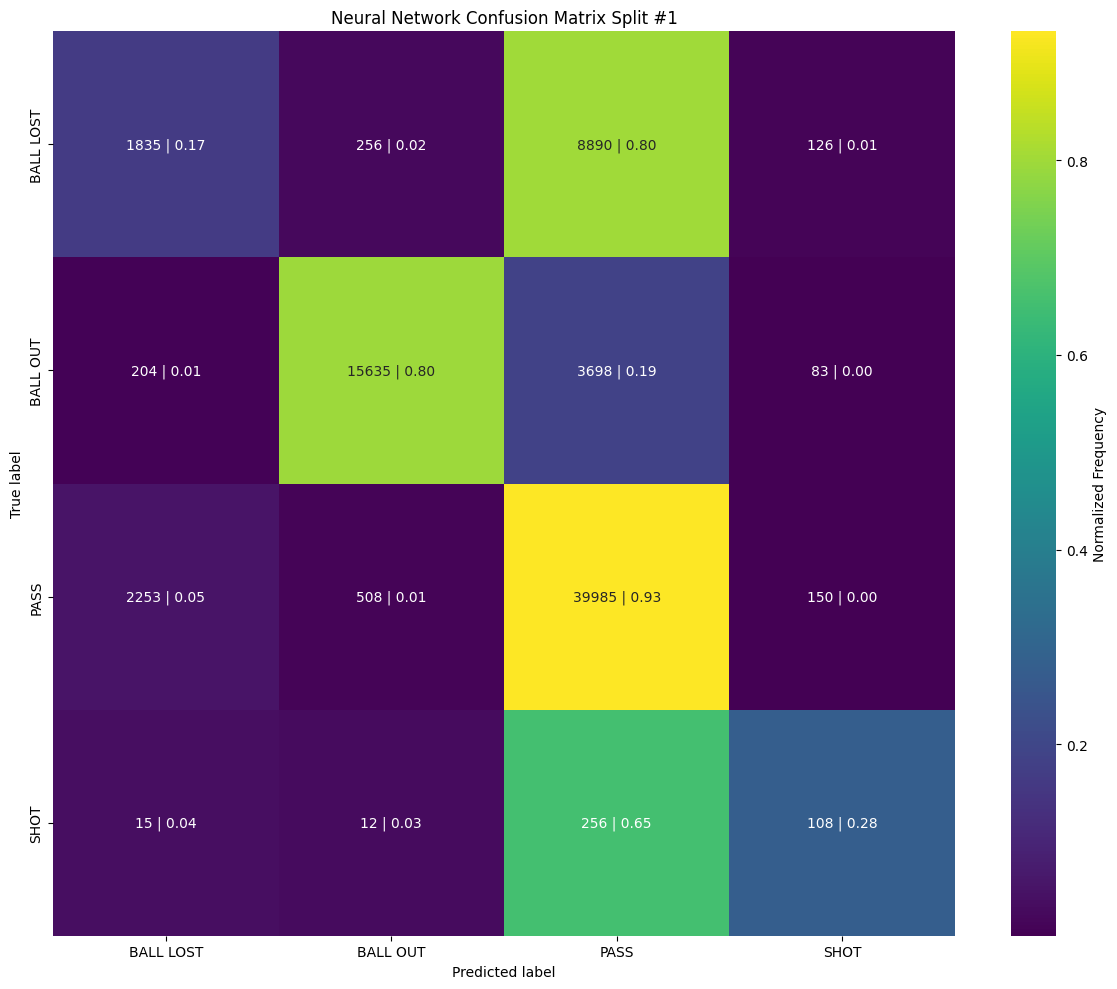

Neural Network training accuracy: 96.09%
Neural Network testing accuracy: 77.77%

Neural Network testing precision: 75.64%
Neural Network testing recall: 77.77%
Neural Network testing f1: 75.13%




In [59]:
plot_accuracy_history(acc, title="None for your@")
labels = label_encoder.inverse_transform(np.unique(y_1_encoded))
_ = plot_confusion_matrix(y_train=label_encoder.inverse_transform(y_train), y_train_pred=label_encoder.inverse_transform(y_train_pred), y_test=label_encoder.inverse_transform(y_true), 
                          y_pred=label_encoder.inverse_transform(y_pred), labels=labels, split=0, model_name="Neural Network")

In [ ]:
plot_accuracy_history(acc, title="None for your")

In [ ]:
plot_accuracy_history(acc, title="More than none for your")

In [ ]:
X_1_tensor = torch.FloatTensor(X_1_scaled)
y_1_tensor = torch.LongTensor(y_1_encoded)

X_2_tensor = torch.FloatTensor(X_2_scaled)
y_2_tensor = torch.LongTensor(y_2_encoded)

X_3_tensor = torch.FloatTensor(X_3_scaled)
y_3_tensor = torch.LongTensor(y_3_encoded)

X = torch.cat((X_1_tensor, X_2_tensor))
y = torch.cat((y_1_tensor, y_2_tensor))

assert X.shape[0] == y.shape[0]

d_1 = TensorDataset(X, y)
d_2 = TensorDataset(X_3_tensor, y_3_tensor)

In [ ]:
def objective(trial):
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])
    num_epochs = 150 
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256, 512])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd'])
    if optimizer_name == "sgd":
        learning_rate = trial.suggest_float('learning_rate', 1e-2, 1, log=True)
    else:
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 3, 15)

    # Update your model's parameters using the trial's suggestions
    nn_params = {
        "input_size": X_1.shape[1],
        "num_classes": np.unique(y_2).shape[0],
        "num_hidden_layers": num_hidden_layers,
        "dropout_rate": dropout_rate,
        "hidden_size": hidden_size,
    }

    # Recreate the model with the current hyperparameters
    nn_model = get_model("nn", nn_params=nn_params).to(device)

    train_loader = DataLoader(d_1, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(d_2, batch_size=batch_size, shuffle=True)

    # Train the model and get the accuracy (or any other metric)
    acc = train_model(nn_model, train_loader, validation_loader, num_epochs, 
                      optimizer_name=optimizer_name, 
                      criterion=nn.CrossEntropyLoss(), 
                      learning_rate=learning_rate, 
                      device=device, verbose=False)
    
    # Return accuracy as the objective metric (Optuna will try to maximize it)
    # print(np.mean(acc["validation_accuracy"][-20:]))
    return np.mean([np.mean(acc["training_accuracy"][-20:]), np.mean(acc["validation_accuracy"][-20:])])

# Create an Optuna study to optimize the objective
study = optuna.create_study(direction='maximize')  # direction='maximize' because we're optimizing accuracy
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print(f"Best trial: {study.best_trial.params}")
print(f"Best accuracy: {study.best_value}")

In [ ]:
42, 15,13

In [ ]:
def plot_accuracy(history, title=""):
    fig, ax = plt.subplots(figsize=(12, 8))

    for metric, results in history.items():
        ax.plot(list(range(1, num_epochs + 1)), results, marker="o", label=metric)
    # ax.plot(list(range(1, num_epochs + 1)), accuracy["testing_accuracy"], marker="o", label="Testing Accuracy")

    ax.set_xlabel("Number of epochs")
    ax.set_ylabel("Training and validation accuracy")
    ax.set_title(f"Learning curve for {title}")
    
    ax.grid(True)
    ax.legend()
    
    plt.show()

In [ ]:
plot_accuracy(acc, title="NN with MinMax scaling")

In [ ]:
plot_accuracy(acc, title="NN with MinMax scaling")

In [ ]:
plot_accuracy(accu, title="NN with MinMax scaling, added batch normalization, Adam optimizer, and 0.2 dropout")

In [ ]:
plot_accuracy(accuracy, title="NN with minmax scaling, added batch normalization, SGD optimizer, and no dropout")

In [ ]:
plot_accuracy(accu, title="NN with minmax scaling, added batch normalization, SGD optimizer, and 0.1 dropout")

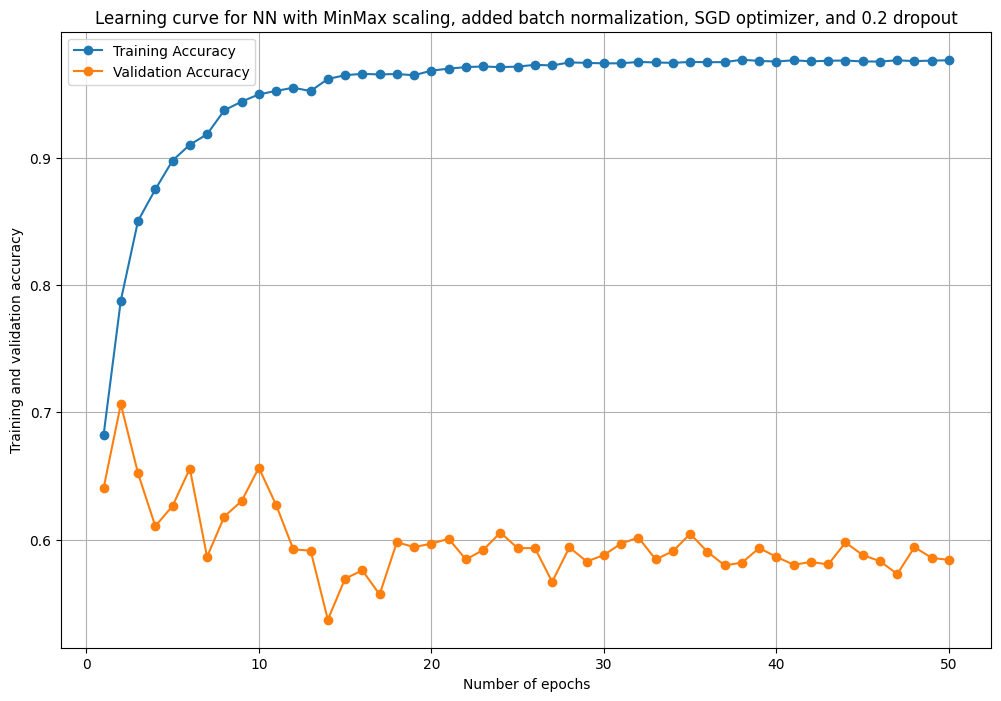

In [62]:
plot_accuracy(accu, title="NN with MinMax scaling, added batch normalization, SGD optimizer, and 0.2 dropout")